# Compare and analyze the used models
Especially why they don't work.

In [1]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Naive stacking of fully-connected layers

### Number of hidden layers

The following plot compares the number of hidden layers (increasing from 1 to 10) and its influence on the resulting loss and accuracy (TODO: How is accuracy calculated?). The validation looks rather strange and its recommended to first check the implementation of the respective calculations.

In [2]:
relpath = "logs/naive-fully-connected"
dirtree = [dirtree for dirtree in os.walk("logs") if dirtree[0] == relpath][0]
filenames = [filename for filename in dirtree[2] if filename[-4:] == ".log"]
# Sort the files by number of hidden layers.
filenames.sort(key=lambda x: int(re.findall(r"""(?<=training_)[0-9]+(?=_)""", x)[0]))
data = tuple(pd.read_csv(os.path.join(dirtree[0], filename), header=0, index_col=0, dtype=np.float32)
             for filename in filenames)

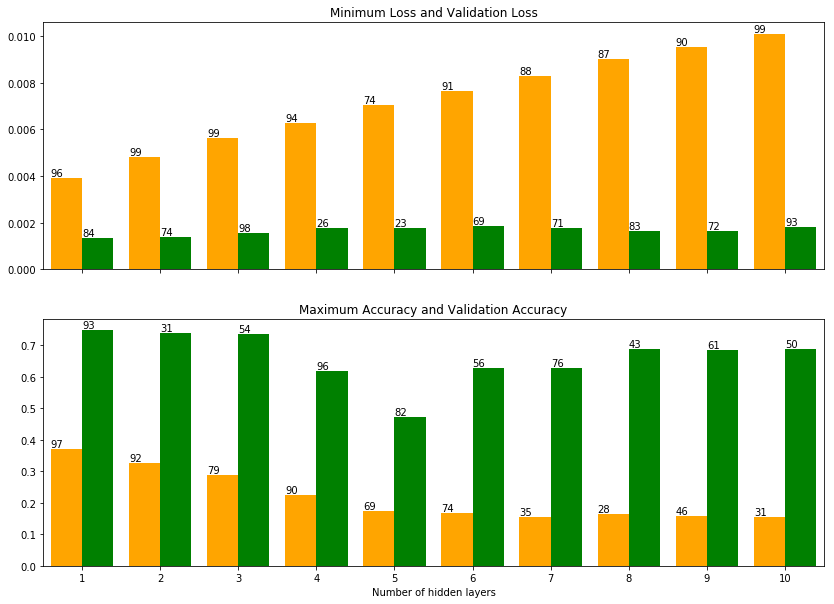

In [3]:
f, axs = plt.subplots(2, sharex=True)
f.set_size_inches(14, 10)
for idx, sample in enumerate(data):
    rect = axs[0].bar(idx + 0.8, sample["loss"].min(), width=0.4, color="orange")
    axs[0].text(rect[0].get_x(), rect[0].get_height(), int(sample["loss"].argmin()) + 1, ha="left", va="bottom")
    rect = axs[0].bar(idx + 1.2, sample["val_loss"].min(), width=0.4, color="green")
    axs[0].text(rect[0].get_x(), rect[0].get_height(), int(sample["val_loss"].argmin()) + 1, ha="left", va="bottom")
axs[0].set_title("Minimum Loss and Validation Loss")
for idx, sample in enumerate(data):
    rect = axs[1].bar(idx + 0.8, sample["acc"].max(), width=0.4, color="orange")
    axs[1].text(rect[0].get_x(), rect[0].get_height(), int(sample["acc"].argmax()) + 1, ha="left", va="bottom")
    rect = axs[1].bar(idx + 1.2, sample["val_acc"].max(), width=0.4, color="green")
    axs[1].text(rect[0].get_x(), rect[0].get_height(), int(sample["val_acc"].argmax()) + 1, ha="left", va="bottom")
axs[1].xaxis.set_ticks(np.arange(1, 11))
axs[1].set_title("Maximum Accuracy and Validation Accuracy")
axs[1].set_xlabel("Number of hidden layers")
axs[1].set_xlim(0.5,10.5)
plt.show()

The numbers above the bars represent the epoch number with the best results. The training was running for 100 epochs in total.

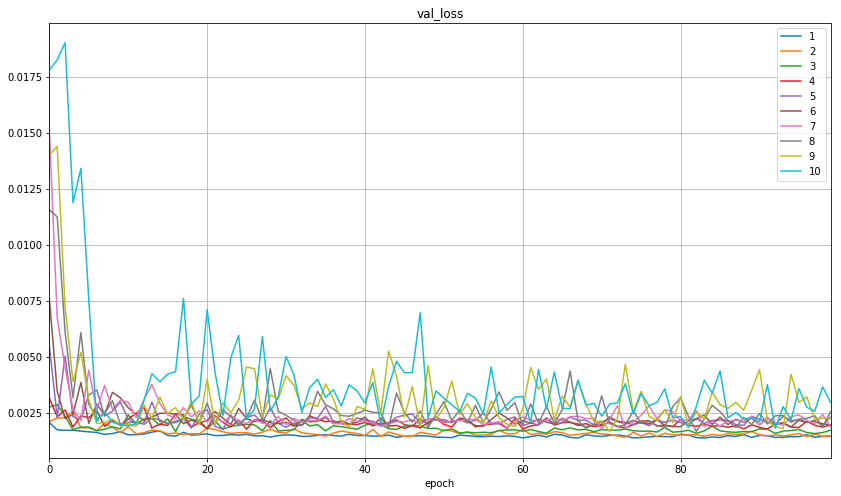

In [14]:
index_title = "val_loss"
for idx, d in enumerate(data):
    d[index_title].plot(figsize=(14,8), label=idx + 1)
plt.title(index_title)
plt.legend()
plt.grid()
plt.show()